# Importing the dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,MinMaxScaler,FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the dataset
df = pd.read_csv('Cleaned_datasets/Combined_CleanData_V4.csv')
df.head(3)

,Property_Type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,furnishing_type,luxury_category,floor_category
0,flat,sector 7,0.45,2.0,2.0,1,Relatively New,1000.0,0,2,Low,Mid Floor
1,flat,sector 3,0.50,2.0,2.0,1,Old Property,722.0,0,0,Low,Low Floor
2,flat,sector 1,0.40,2.0,2.0,3,New Property,661.0,0,2,Low,High Floor


In [3]:
# Seperating the data into dependent variable and indepenedent variables
X = df.drop(['price'],axis=1)
y = df['price']

X_train,X_test_val,y_train,y_test_val = train_test_split(X,y,train_size = 0.8,shuffle=True)
X_test,X_val,y_test,y_val = train_test_split(X_test_val,y_test_val,train_size=0.8,shuffle=True)

In [4]:
X_train.shape,X_test.shape,X_val.shape

((2974, 11), (595, 11), (149, 11))

In the input data which we will be feeding into the model for training, there is only 1 feature which is continuous in nature and that is `built_up_area` and to get good results from the linear models, the distribution of continous features must be normal or sort of normal. Thus we will be using some mathematical transformation to transform the skewed distribution into the sort of normal distribution. 

In similar way we will also be using some mathematical transformation on target variable, but to decide which transformation to apply we must be aware about the shape of the variable's distribution, thus we will be using a `histogram` and a `qqplot`

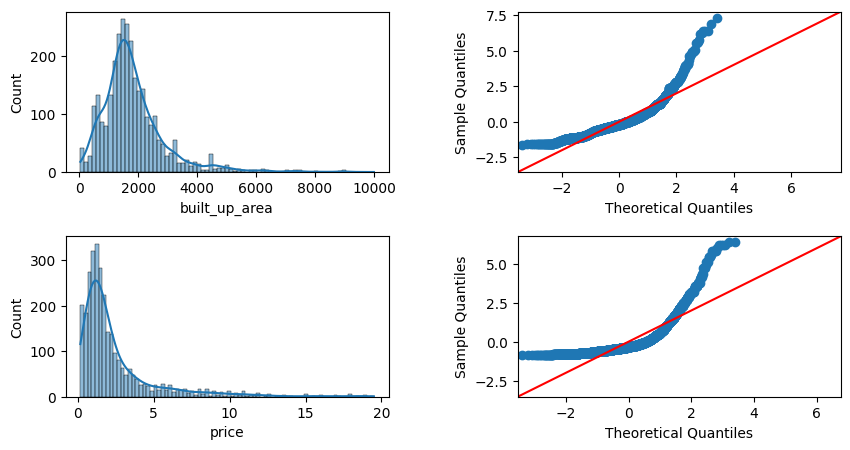

In [5]:
fig, ax = plt.subplots(2, 2, figsize=[10, 5])

sns.histplot(data=X_train, x='built_up_area', kde=True, ax=ax[0][0])
sm.qqplot(X_train['built_up_area'].values, line='45', fit=True, dist=stats.norm,ax=ax[0][1])
sns.histplot(x=y_train, kde=True, ax=ax[1][0])
sm.qqplot(y_train.values, line='45', fit=True, dist=stats.norm,ax=ax[1][1])

plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.show()

Since the distribution is right skewed thus `log transformation` to transform the right-skewed distribution to a sort of normal distribution.

A ***log transformation*** is a mathematical operation that takes the logarithm of each value in a dataset. This has the effect of compressing the large values in the dataset and expanding the small values. This can be effective for transforming right-skewed distributions to normal distributions, because the log transformation tends to pull the tail of the distribution towards the center.

In [6]:
# Defining the function transformer for doing log transformation
trf = FunctionTransformer(func=np.log1p)

In [7]:
X_train['built_up_area'] = trf.fit_transform(X_train['built_up_area'])
X_test['built_up_area'] = trf.fit_transform(X_test['built_up_area'])

y_train = trf.fit_transform(y_train)

# Processsing Pipeline
Before training our model it is very much important to first transform the data into the form which the model accepts (Numbers). In the feature selection file we build a base model and that model was performing average, so now in this file our aim will be to use the best set of techniques for encoding the categorical data, as well as performing any necessary mathematical transformations on the numerical features to get the best possible model with current data we are having at hand.

In this module we will focusing on performing 3 different operations ⬇️
- Encoding categorical data
- Applying mathematical transformation to make skewed feature: sort of normal
- Scale the feature values to common scale

#### Step 1: Encoding categorical features
- In our dataset property type and sector are 2 nominal features
- Age possession, luxury cateogry and floor category are ordinal features

`Note`: An important thing that we need to keep in mind is that the feature `sector` is having high cardinality so one hot encoding may lead to curse of dimensionality, so we need to test that for this feature whether one hot encoding or target encoding will work. 

In [8]:
# Instantiating target encoder class
Target_Encoder = ce.TargetEncoder()

# Fit the TargetEncoder to the training data
Target_Encoder.fit(X_train['sector'], y_train)

# Transform the training data using the TargetEncoder
X_train['sector'] = Target_Encoder.transform(X_train['sector'])
X_test['sector'] = Target_Encoder.transform(X_test['sector'])

In [9]:
X_train.head(2)

,Property_Type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,furnishing_type,luxury_category,floor_category
1859,flat,1.191564,2.0,2.0,3,New Property,6.994850,0,2,Low,Mid Floor
2619,flat,1.205363,3.0,4.0,3+,Relatively New,7.579168,0,2,Medium,Mid Floor


In [33]:
# Column transformer for doing ordinal and nominal encoding
encoding_transformer = ColumnTransformer(transformers = 
                                         
                    [('Encode_PropT',OneHotEncoder(handle_unknown='ignore',drop='first'),[0]),

                    ('Encode_balcony',OrdinalEncoder(categories=[['0','1','2','3','3+']],
                    handle_unknown="use_encoded_value",unknown_value = np.nan),[4]),
    
                    ('Encode_AgeP',OrdinalEncoder(categories=[['Under Construction','New Property','Relatively New', 
                    'Moderately Old','Old Property']],handle_unknown="use_encoded_value",unknown_value = np.nan),[5]),

                    ('Encode_Lux',OrdinalEncoder(categories=[['Low','Medium','High']],
                    handle_unknown="use_encoded_value",unknown_value = np.nan),[9]),

                    ('Encode_Floor',OrdinalEncoder(categories=[['Low Floor','Mid Floor','High Floor']],
                    handle_unknown="use_encoded_value",unknown_value = np.nan),[10])],remainder='passthrough')

# Column transformer for doing feature scaling
scaling_transformer = ColumnTransformer(transformers = [
    ('MinMaxScaling',MinMaxScaler(copy=False),[0,1,2,3,4,5,6,7,8,9,10])],remainder='passthrough')


# Stacking column transformers to create a Processing pipeline
Processing_pipeline = Pipeline(steps = [('Encoding',encoding_transformer),
                             ('Scaling',scaling_transformer)],memory='Temp')

In [11]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(Training_pipeline, X_train, y_train, cv=kfold, scoring='r2')

In [12]:
scores.mean(),scores.std()

(0.8054399748806839, 0.029503099531468454)

In [13]:
def scorer(model_name, model):
    """
    This function will take a model name as input and inject that model into the training pipeline to process 
    and train the model by using the training data. After that this function will use K fold cross validation technique
    to calculate the average (r2 score) and the mean absolute error
    """
    
    output = []
    output.append(model_name)
    
    # Stacking column transformers to create a Training pipeline
    Training_pipeline = Pipeline(steps = [('Encoding',encoding_transformer),
                             ('Scaling',scaling_transformer),
                             ('regressor', model)])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(Training_pipeline, X_train, y_train, cv=kfold, scoring='r2')
    output.append(scores.mean())
    
    # Training the model and getting predictions
    Training_pipeline.fit(X_train,y_train)
    y_pred = Training_pipeline.predict(X_test)
    y_pred = np.expm1(y_pred)
    output.append(mean_absolute_error(y_test,y_pred))
    
    return output

In [14]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [15]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [16]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])
model_df.sort_values(['mae'])

,name,r2,mae
10,xgboost,0.892659,0.445935
6,extra trees,0.890264,0.448743
5,random forest,0.894033,0.449129
7,gradient boosting,0.880610,0.549436
4,decision tree,0.817355,0.617677
9,mlp,0.848239,0.618603
1,svr,0.852491,0.625393
0,linear_reg,0.805440,0.654150
2,ridge,0.805418,0.654890
8,adaboost,0.798500,0.684113


# Hyper parameter optimization 
HYPEROPT is a powerful python library that uses bayesian optimization to search through an hyperparameter space of values and find the best possible values that yield the minimum of the loss function.The optimization process consists of 4 parts which are as follows-

1. **Initialize domain space**
The domain space is the input values over which we want to search.

2. **Define objective function**
The objective function can be any function which returns a real value that we want to minimize. In this case, we want to minimize the validation error of a machine learning model with respect to the hyperparameters. If the real value is accuracy, then we want to maximize it. Then the function should return the negative of that metric.

3. **Optimization algorithm**
It is the method used to construct the surrogate objective function and choose the next values to evaluate.

4. **Results**
Results are score or value pairs that the algorithm uses to build the model.

In [17]:
X_train = Processing_pipeline.fit_transform(X_train,y_train)
X_test = Processing_pipeline.transform(X_test)

In [18]:
# Defining the domain space
space = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': 180,
    'seed': 0 }


def objective(space):
    model = XGBRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight=int(space['min_child_weight']),
        random_state=space['seed'])

    # Training the model
    model.fit(X_train, y_train)

    # Getting predictions from the trained model and computing mean absolute error
    y_pred = model.predict(X_test)
    y_pred = np.expm1(y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print("MAE:", mae)
    return {'loss': mae, 'status': STATUS_OK }

In [19]:
trials = Trials()
best_hyperparams = fmin(fn=objective,space=space,algo=tpe.suggest,max_evals=100,trials=trials)

MAE:                                                                            
0.6039791411912743                                                              
MAE:                                                                            
0.533734328109677                                                               
MAE:                                                                            
0.5996922655987138                                                              
MAE:                                                                            
0.6083031537913475                                                              
MAE:                                                                            
0.5988240159699897                                                              
MAE:                                                                            
0.6132570828610108                                                              
MAE:                        

In [20]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.9998986669717084, 'gamma': 0.003750998198734907, 'max_depth': 11.0, 'min_child_weight': 2.0, 'reg_alpha': 0.2766951313271483, 'reg_lambda': 0.039111730323653546}


# Model training

In [41]:
# Create the XGBoost Regressor with the best hyperparameters
regressor = XGBRegressor(
    max_depth=int(best_hyperparams['max_depth']),
    gamma=best_hyperparams['gamma'],
    reg_alpha=best_hyperparams['reg_alpha'],
    reg_lambda=best_hyperparams['reg_lambda'],
    colsample_bytree=best_hyperparams['colsample_bytree'],
    min_child_weight=best_hyperparams['min_child_weight'],
    n_estimators=180,
    random_state=0)

# Training the model
regressor.fit(X_train,y_train)

# Model evaluation

In [43]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(regressor, X_train, y_train, cv=kfold, scoring='r2')
print("Average R2 SCORE : ",scores.mean())

Average R2 SCORE :  0.8908036551397064


In [44]:
# Getting predictions
y_pred = regressor.predict(X_test)
y_pred = np.expm1(y_pred)
print("Mean Absolute error:",mean_absolute_error(y_test,y_pred))

Mean Absolute error: 0.4317201067960564


# Saving the trained Model

In [45]:
# Specify the file path where you want to save the model
model_path = 'Trained_Model/xgboost_regressor_model.bin'

# Save the model to the specified file
regressor.save_model(model_path)